# Lab 9 - Reward seeking

This lab has 3 main components designed to give you an interactive understanding of core reinforcement learning concepts and the $\epsilon$-greedy reinforcement learning algorithm.

Sections:
0. Background on essential reinforcement concepts that we will be engagning with hands-on.
1. Investigating random and $\epsilon$-greedy algorithms in a simple bandit task.
2. Seeing how this sort of policy works in our foraging search.

# New Section

## Background

### The bandit task

In this assignment we study exploration in the very abstract $k$-armed bandit task.
- In this there are $k$ actions to take.
- Each returns a reward $R$, with some probability $p$.
- The reward value is either a 1 or a 0.
- This means the expected value of each arm is simply probability. Nice and simple right?

### Action-value learning

Our agents are really learning, at last. Reinforcement Learning (RL), to be precise.

The reward value $Q$ update rule for all agents (below) and arm is the same:

$ Q \leftarrow Q + \alpha * (R - Q) $ [1]

Where the learning rate on the reward prediction error ($R-Q$) is denoted as $\alpha$, so that the equation above looks nice. If you are not familiar with the idea of a learning rate, it is what it sounds like. A parameter that controls how much each value update matters. This is, over time, the rate at which learning happens.

$Q$ is trying to approximate the average reward value of each arm.

- This kind of difference $(R - Q)$, the reward prediction error (RPE), in Eq [1] is the most typical error signal used for learnin gin RL.
- If you're not sure what it means, consider in your head, what would happen to the value update if $Q$ was bigger than the reward $R$ (and overestimate), or if it was smaller.

Once you have noodled that a bit, as needed, consider how making $\alpha$ bigger or smaller might make $Q$ learning faster, or slower, or more or less volatile. (Learning speed and volatility _often_ go together; an annoying matched set.)

_Note_: We are not going to really play with $\alpha$ here. Just giving you some intuition.

### Basic exploration strategies

Our exploration strategies are a random one, a sequential one, or $\epsilon$-greedy (aka 'e'-greedy).

The $\epsilon$-greedy method is not the best known solution to trading off exploration with exploitation. Then again, it is widely used to this day. It's a place to start.

Our metric is _total reward_. Maximizing that is the goal of all RL, afterall.

## Section - Setup

In [2]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-8mwc2vzr
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-8mwc2vzr
  Resolved https://github.com/coaxlab/explorationlib to commit 6ed899dafd40d0c87bf5fd1d44e0af610b8eab75
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42775 sha256=d9be05bd8e0edf1cfbba7ae71aed31d198f430724832edc62581ecdd0747d204
  Stored in directory: /tmp/pip-ephem-wheel-cache-a8ekflf8/wheels/71/57/e8/88c93e85ce02efaef024038b2ddcb6c6dec8a1a212f712bb05
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-lqqsvut0
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-lqqsvut0
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

In [3]:
# Import misc
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exploration lib
import explorationlib

# Agents
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor
from explorationlib.agent import WSLSGrid
from explorationlib.agent import CriticGrid
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import ActorCriticGrid
from explorationlib.agent import DiffusionGrid

# Exp
from explorationlib.run import experiment
from explorationlib.score import total_reward
from explorationlib.score import action_entropy
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Vis
from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death
from explorationlib.score import on_off_patch_time

# Env
from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_grid_scent_patches
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import uniform_patch_targets
from explorationlib.local_gym import constant_values


/usr/local/lib/python3.10/dist-packages/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_re

In [4]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - The bandit task

In this section we'll study three explorers getting to know one bandit, with four arms.

**Creating a bandit task**

Let's make a 4-armed bandit and then plot its values. (Expected value is the term used in the literature, so we use it here).

_Note_: The random seed is fixed. If you change the see and run the cell below, some of the reward probabilities will change. The probability of the best arm, the optimal value arm is fixed however. It is set to 0.35, and located at arm 2. Try it! Rerun the cell below with different seeds, a few times, to get a sense of how the non-optimal arms can vary. When you are done, return to the orginal seed value and re-run.

<Axes: xlabel='Arm', ylabel='Expected value'>

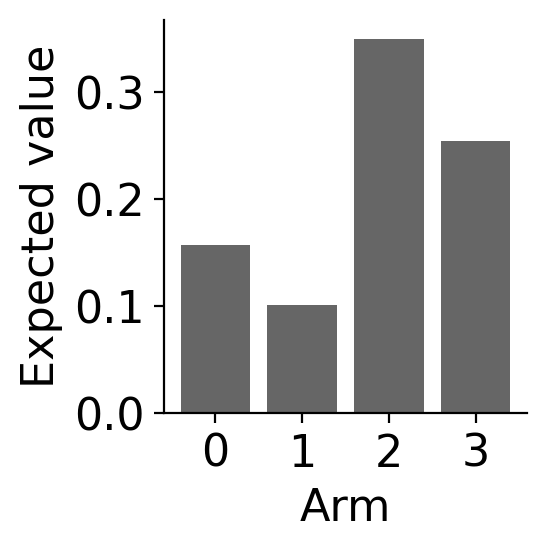

In [5]:
# Shared env params
num_experiments = 1
seed = 5030 # originally 5030

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

---
### Question 1.1

Given the reward probabilities (expected values) in this bandit task, how "easy" or "difficult" do you think this task would be to learn from a simple update rule like we showed above? Why?

__Answer:__

The task is relatively **easy** to learn using the simple update rule because the reward probabilites are distinct, with one arm (2) clearly having the highest expected value (0.35). The ep-greedy alogrithm effectively balances exploration and exploitation, allowing the agent to discover the optimal arm over time.

**Our three agents**

A word about the code. Our agents this week work in what gets called an ActorCritic desgin. This breaks reinforcement learning algorithms into two parts: the Actor does action selection, and the Critic estimates the value of each action.

Now in normal reinforcement learning, aka not pure exploration, the _Actor_ uses the $Q$ value estimates from the _Critic_ to, in part, make its decisions. Be it explore or exploit. This is indeed the case for how the $\epsilon$-greedy agent, _EpsilonActor_, works.

...But...

The other two agents--_SequentialActor_ and _RandomActor_--don't explore with value. The are both _max entropy_ action systems, who don't care about reward value or learning _at all_. The _ActorCritic_ style is reused because it was easy to implement in _explorationlib_. Don't be misled.

In [6]:
# Creating the three agents

ran = BanditActorCritic(
    RandomActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
seq = BanditActorCritic(
    SequentialActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# -
agents = [ran, seq, epy]
names = ["random", "sequential", "ep-greedy"]
colors = ["blue", "green", "purple"]

Let's run out our three agents on the _env_ (the bandit task we built), and make some plots to visualize what each agent is doing.

In [12]:
num_steps = 12  # Number of choices each agent gets to make, (around 3 per arm)

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

random:   0%|          | 0/1 [00:00<?, ?it/s]

sequential:   0%|          | 0/1 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/1 [00:00<?, ?it/s]

**Plot action choices**
with time (aka steps).

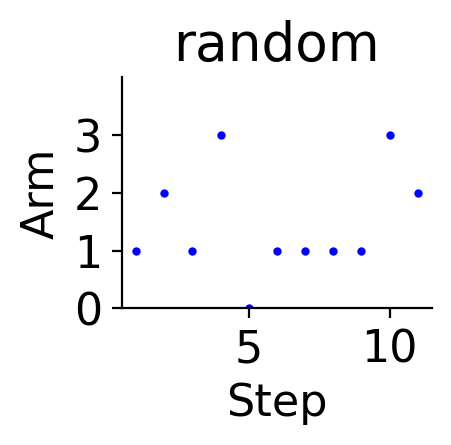

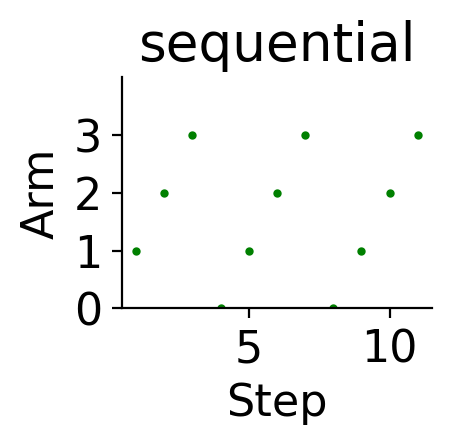

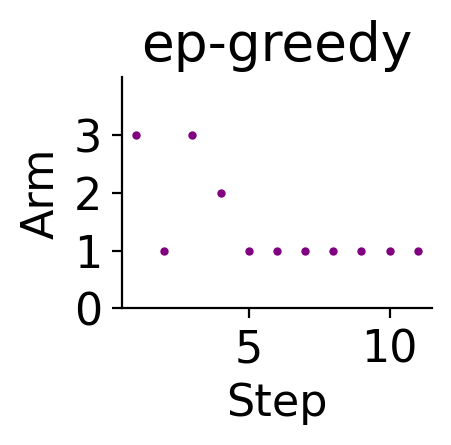

In [13]:
num_experiment = 0
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment),
        num_arms=4,
        s=4,
        title=name,
        color=color,
        figsize=(2, 1.5)
        )

---
### Question 1.2

Describe the choice behavior of each agent type.

__Answer:__

**Random Agent** - This agent selects actions purely at random without considering past outcomes or reward values. The choice pattern appears scattered across all the arms with no apparent strategy or preference.

**Sequential Agent** - This agent selects actiosn in a fixed sequential order, cyling through all the availbel arms regardless of reqards. This choise pattern was predictable, evening distribuated across the arms in order. This agent ensures that all samples are sampled at least once.

These two agents (random and sequential) are not driven by information.

**Epsilon-greedy Agent** - This agent primarily exploits the arms with the highest estimated reward  (based on Q values) but occasionally explores other arms with a small probability (epsilon). The choice pattern shows a strong preference for the optimal arm with limited exploration of others.

---
### Question 1.3

Re-run the simulations above a few times. What range of choice patterns does epsilon-greedy agent exhibit? What do you think leads to these patterns?

__Answer:__

The epsilon-greedy agent shows two main patterns: it mostly exploits the optimal arm after brief exploration or occasionally explores suboptimal arms due to the epsilon probability.

The different patterns come from a mix of exploration (trying different arms randomly) and exploitation (sticking to the best arm it has found so far). The randomness in exploration (caused by epsilon) means the agent might choose suboptimal arms even when it knows a better one.

Early random choices affect how much the agent learns about each arm, and since the experiment only runs for a few steps, the agent doesn't always have enough time to learn which arm is truly the best. This is why the patterns may vary: sometimes the agent quickly finds the best arm, and sometimes it doesn't because of those random early steps.

---
### Question 1.4

Now change the ϵ value for the ϵ-greedy agent to $0.01$ and re-run the simulations a few times. How does the behavior of this agent change? What does this tell you about the utility of greediness in this particular form of the bandit task?

__Answer:__

When epsilon is reduced to 0.01, the agent explores much less, focusing almost entirely on exploiting the arm it believes is best first. This makes it quicker to settle on an arm, but if it initially picks a suboptimal arm, it's less likely to discover the true best arm due to limited exploration.

This shows that while lower epsilon can work well if the agent quickly identifies the optimal arm, it risks getting stuck on a suboptimal arm if the early random choices are unlucky. For this bandit task, I think that some exploration is necessary to ensure the agent finds the best arm reliably.

**Histograms of action probability (aka arm choice).**

_Fun fact_: The flatter these plots are, the closer they are to what is called _maximum entropy_ exploration behavior.

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

action_entropy:   0%|          | 0/1 [00:00<?, ?it/s]

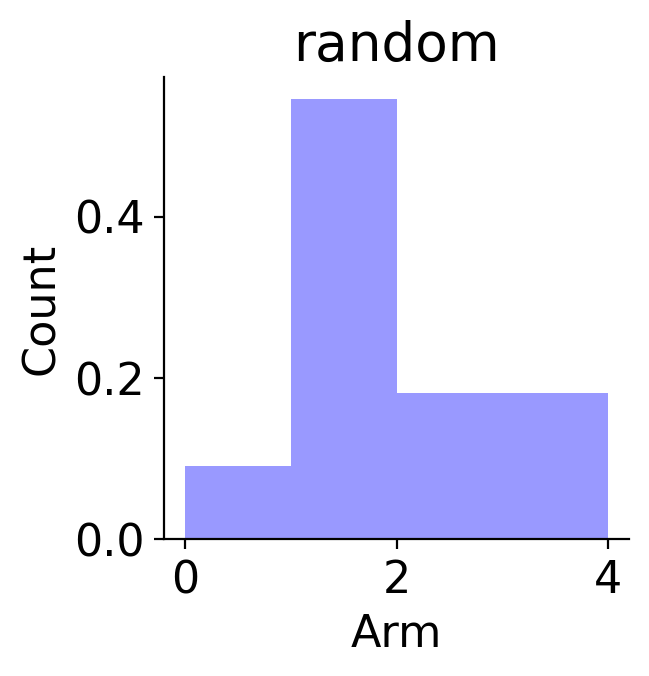

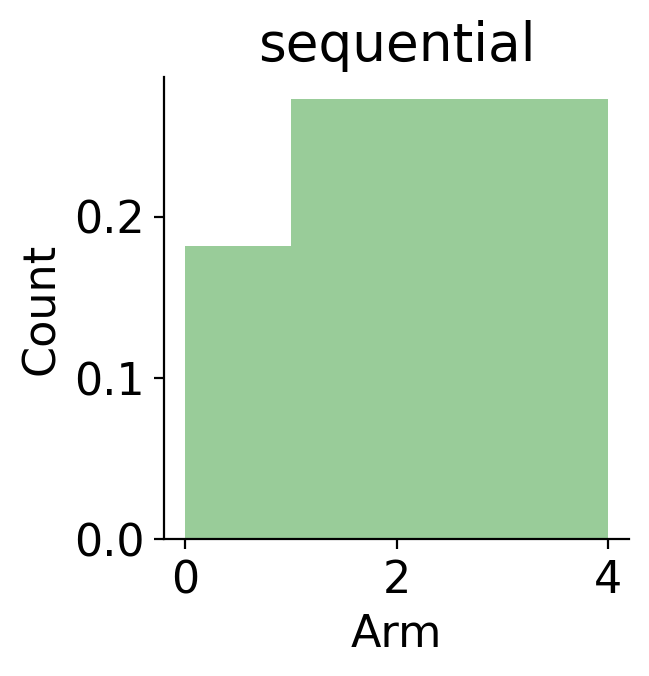

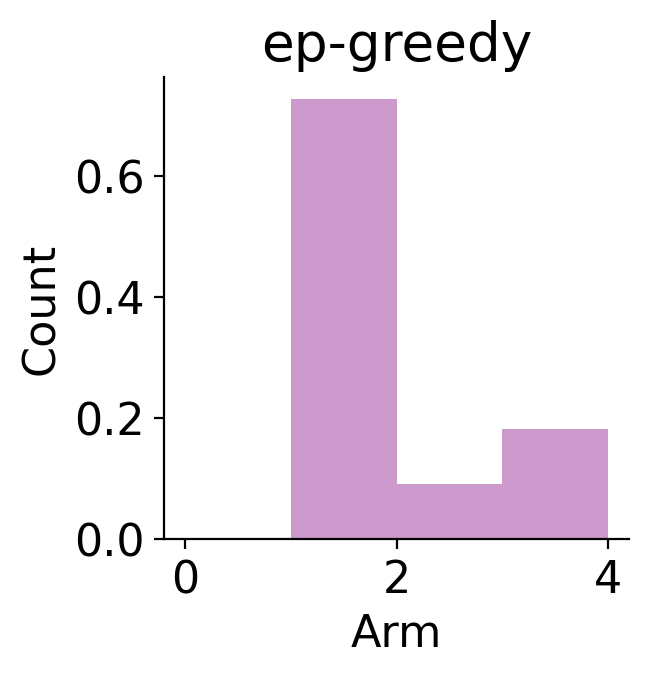

In [15]:
num_experiment = 0
ax = None
for name, res, color in zip(names, results, colors):
    ent = np.round(np.mean(action_entropy(res)), 2)
    plot_bandit_hist(
        select_exp(res, num_experiment),
        bins=list(range(0, 5)),
        title=f"{name}", # (ent {ent})",
        alpha=0.4,
        color=color,
        figsize=(3, 3),
        ax=ax
        )

## Section 2 - Investigating the epsilon-greedy algorithm

**Meet our dilemma**
I've been learning Q-value estimates.
* Should I explore (keep sampling the options to get more data points to update Q-value estimates)?
* Should I exploit (choose the action whose Q value estimate is currently the greatest)?

*A simple strategy:*

....I'll flip a weight coin,

...who's weight has a name. It's $\epsilon$!

The smaller $\epsilon$ is, the less likely the coin flip comes up "EXPLORE''. The more likely it comes up on the "EXPLOIT" side. If one chooses the exploit side, one is being greedy, right? The bigger $\epsilon$ the more likely the coin will say "EXPLORE ''. Etc.

Let's play with $\epsilon$-greedy, on our base case bandit task.

---
### Question 2.1

We will run three differnt epsilon-greedy agents, each with a different epsilon value (0.05, 0.5, and 0.95). What do you expect each agent's stepwise behavior to "look like"? Why?

__Answer:__

**epilson = 0.05**: The agent will mostly exploit the arm it thinks is the best, with very little exploration. Its stepwise behavior will heavily favor one arm, with rare random choices.

**epsilon = 0.5**: The agent will have a balanced mix of exploration and exploitation. Its choices will alternate between testing different arms and selecting the one with the highest estimated reward.

**epsilon = 0.95**: The agent will mostly explore and rarely exploit the best-known arm. Its behavior will appear random, with frequent switches between arms.

In [25]:
num_steps = 4 * 100
epsilons = [0.05, 0.5, 0.95]

names = [str(epsilon) for epsilon in epsilons]
colors = ["mediumpurple", "mediumorchid", "mediumvioletred"]

# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        Critic(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

ep_0:   0%|          | 0/100 [00:00<?, ?it/s]

Example behavior visualizations below. Change _num experiment_ to see more examples (0, 99).

_Note_: in every experiment we run in this lab, the optimal value arm is _always_ arm 2.

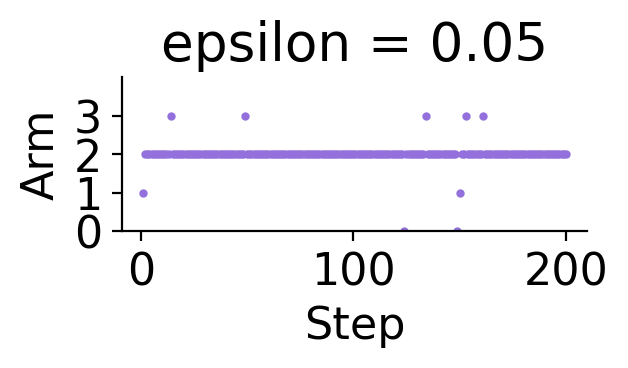

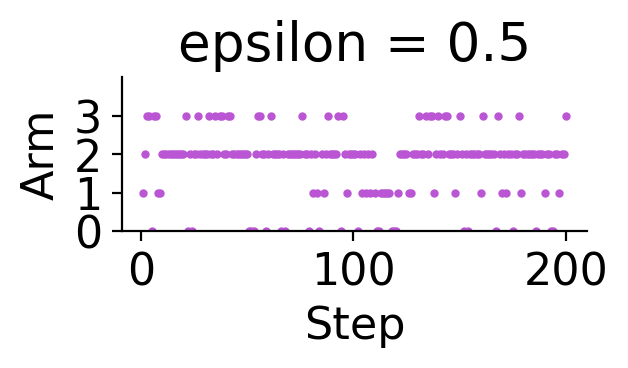

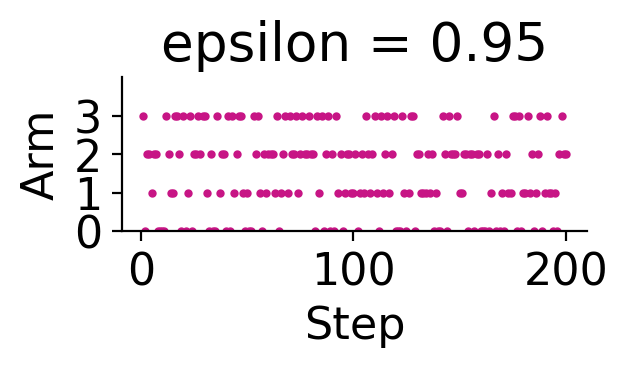

In [26]:
num_experiment = 3
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment),
        max_steps=200,
        s=4,
        title="epsilon = " + name,
        color=color,
        figsize=(3, 1)
        )

---
### Question 2.2

Did the behavior match what you expected? If not, describe the actual behavior and explain what you think is behind it.

__Answer:__

**epsilon = 0.05**: The agent quickly focused on the optimal arm (arm 2) with minimal exploration, as expected for a low ε value prioritizing exploitation.

**epsilon = 0.5**: The agent balanced exploration and exploitation, frequently testing other arms while still favoring arm 2, consistent with moderate epsilon.

**epsilon = 0.95**: The agent explored heavily across all arms, showing little focus on the optimal arm, as expected for a high epsilon prioritizing exploration.

---
### Question 2.3

Re-run the stepwise choice behavior visualization at different `num_experiment` settings to view what happens in different experiments. Find a case when epsilon=0.05 agent didn't select the best arm (Arm 2) very much. How do you think this happened?

__Answer:__

**num_experiment = 50**

If the epsilon = 0.05 agent didn't select the best arm (Arm 2) very much, it likely happened due to unlucky early exploration. Early in the experiment, the agent may have randomly chosen other arms more often, receiving reward signals that temporarily made them seem better than Arm 2. Because the agent only essentially explores 5% of the time, it didn't revisit Arm 2 enough to realize it was the best arm.

This shows that with low exploration (small epsilon), the agent heavily relies on its initial observations, which can skew its decisions if the early rewards for Arm 2 are lower or the other arms appear better initially.

---
### Question 2.4

We will visualize the average total reward for each agent next. Which agent do you think will collect the most reward and which one the least? Why?

__Answer:__

The **epsilon = 0.05** agent will likely collect the most total reward because it quickly identifies and exploits the best arm (Arm 2) with minimal exploration, maximizing rewards over time.

The **epsilon = 0.95** agent will likely collect the least total reward because it spends most of its time exploring all arms, including suboptimal ones, and rarely exploits the optimal arm, resulting in lower overall rewards.

The **epsilon = 0.5** agent is expected to achieve moderate rewards as it balances exploration and exploitation, identifying the optimal arm but spending more time exploring than the epsilon = 0.05 agent.


**Visualize total reward**

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

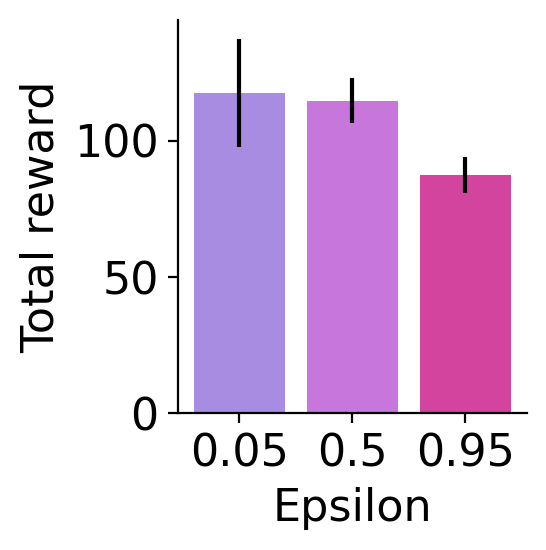

In [27]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

---
### Question 2.6

Were your predictions in questions 2.4 and 2.5 correct? If not, describe the actual results and explain what you think led to them.

__Answer:__

Yes, my predictions in question 2.4 was correct.

**Visualizing a histogram of average choice reward across experiments**

To get average choice reward for each experiment, we divide the total reward for the experiment by the number of steps (choices) taken to collect that total reward.

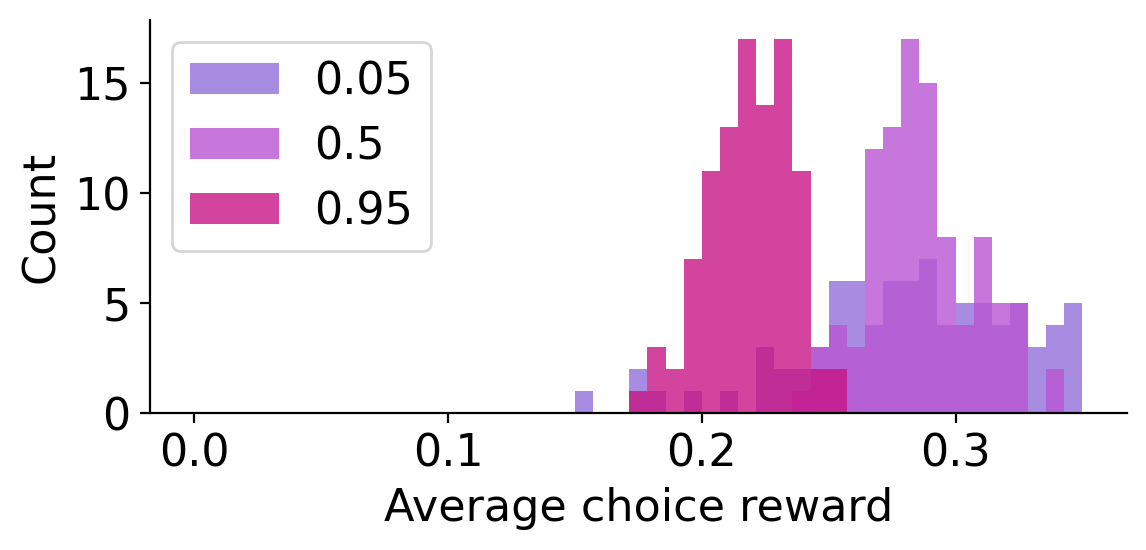

In [28]:
fig = plt.figure(figsize=(6, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(np.array(s)/num_steps, label=name, color=c, alpha=0.8, bins=np.linspace(0, 0.35, 50))
    plt.legend()
    plt.xlabel("Average choice reward")
    plt.ylabel("Count")
    plt.tight_layout()
    sns.despine()

---
### Question 2.7

If instead of 400 steps in each experiment we let each agent run to near infinity, what would the above histogram look like and why?

__Answer:__

**epsilon = 0.05: Tall, narrow peak near 0.3**
*   The histogram would narrow and shift entirely to the right, centered near the maximum average reward (~0.3). This is because the agent explores very little and quickly exploits the optimal arm (Arm 2), leading to consistently high rewards.

**epsilon = 0.5: Broader peak centered around 0.2**
*   The histogram would still be spread out, but it would narrow slightly compared to the current plot. The peak would remain in the middle (around 0.2). This is because the agent balances exploration and exploitation. While it does exploit the optimal arm sometimes, frequent exploration of suboptimal arms prevents it from achieving the highest possible reward.

**epsilon = 0.95: Very wide and flat distribution, centered below 0.2**
*   The histogram would remain wide and spread further left, with most of the distribution centered below 0.2. The high exploration rate means the agent rarely focuses on the optimal arm, spending most of its time testing all arms, leading to a consistently low average reward.

---
### Question 2.8

Based on what you've seen here today, if you were to follow an ϵ-greedy policy for choices in your own life, what value of ϵ would you choose? Why?

__Answer:__

If I were to follow an epsilon-greedy policy in my own life, I would choose a moderate to low epsilon value, such as 0.1. This strikes a balance between exploring new opportunities and exploiting what I already know works well. A moderate/low epsilon allows me to focus on actions or decisions with proven benefits, while still leaving room for occasional exploration to avoid being stagnant or too comfortable and discover potentially better options.

For example, in career or personal development, I would mostly stick to strategies that have been successful but occasionally try new methods to ensure I'm not missing out on growth opportunities. Clearly I'm not too much of a risk-tasker :)

## Section 3 - Reward driven search

Now we are going to create an agent in our foraging environment that implements reward driven search using the exact same approaches we have described above. We shall call this process _rewardtaxis_.

This is a Q-learning agent that uses softmax exploration policiy, as opposed to an $\epsilon$-greedy policy. It does not use teh scent, but wanders until it finds a target, notes the value (reward) of each position on the grid and makes it immediate choices based onthe value of the four possible actions (up, down, left, right) from the current position.

We start by setting up our patchy environment.

In [29]:
# Noise and delete
p_scent = 0.1
noise_sigma = 2.0

# Shared
num_experiments = 100
num_steps = 500
seed_value = 5838
num_targets = 20 # with 80 agents are more competitive!

# Environment parameters
n_patches = 8 #         # number of patches
n_per_patch = 20 #      # number targets per patch
radius = 1 #            # radius of each patch
target_boundary = (10, 10)


# ! (leave alone)
detection_radius = 1
cog_mult = 1
max_steps = 1
min_length = 1

# Targets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

**Getting to know you, RL**

For this demo we will set up two agents:

- Rando: random walker just like we have been using before.
- RL: An agent that uses reinforcement learning (Q-learning) to track a target.

We are going to give each of our agents 99 tries at the _same_ environment. We want to see how repeated exposure to the same environment will improve performance in our agents.

In [30]:
# RL
possible_actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
critic = CriticGrid(default_value=0.5)
actor = SoftmaxActor(num_actions=4, actions=possible_actions, beta=20)
rl = ActorCriticGrid(actor, critic, lr=0.1, gamma=0.1)

# Rando

diff = DiffusionGrid()
diff.seed(seed_value)

# !
rl_exp = experiment(
    f"RL",
    rl,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

RL:   0%|          | 0/100 [00:00<?, ?it/s]

rand:   0%|          | 0/100 [00:00<?, ?it/s]

To start, let's just look at one example of the movement of our random agent, for comparison with the cells below

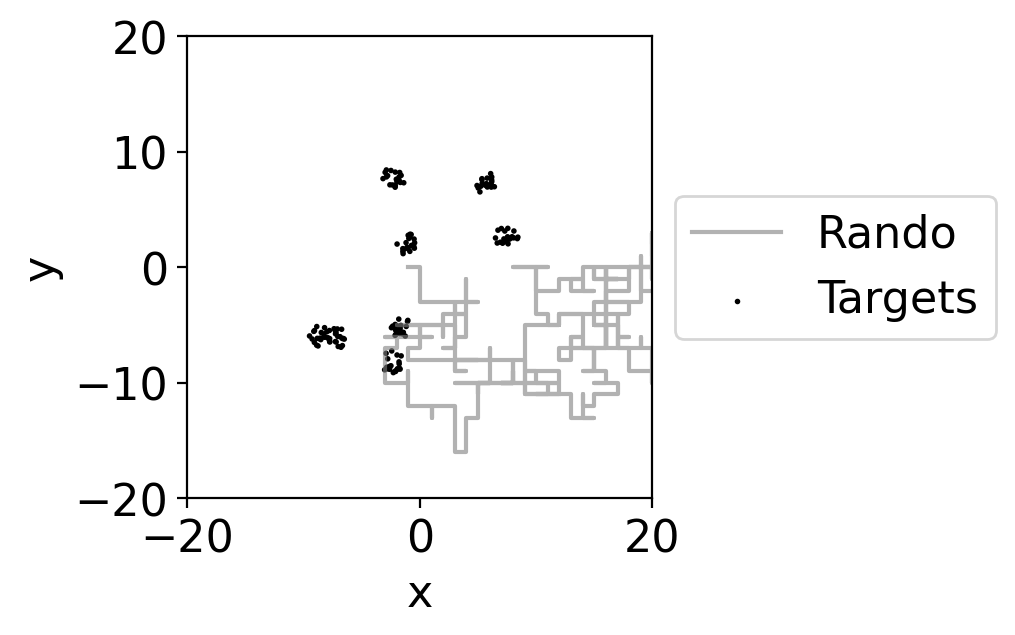

In [31]:
plot_boundary = (20, 20)

# -
num_experiment = 99
ax = None
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label=f"Rando",
    color="grey",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

So our little friend is doing just fine in this random case.

Now let's look at our our RL agent progresses over runs of the experiment. We'll look at at three time points (N=0, early; N=50, middle; N=99, late)

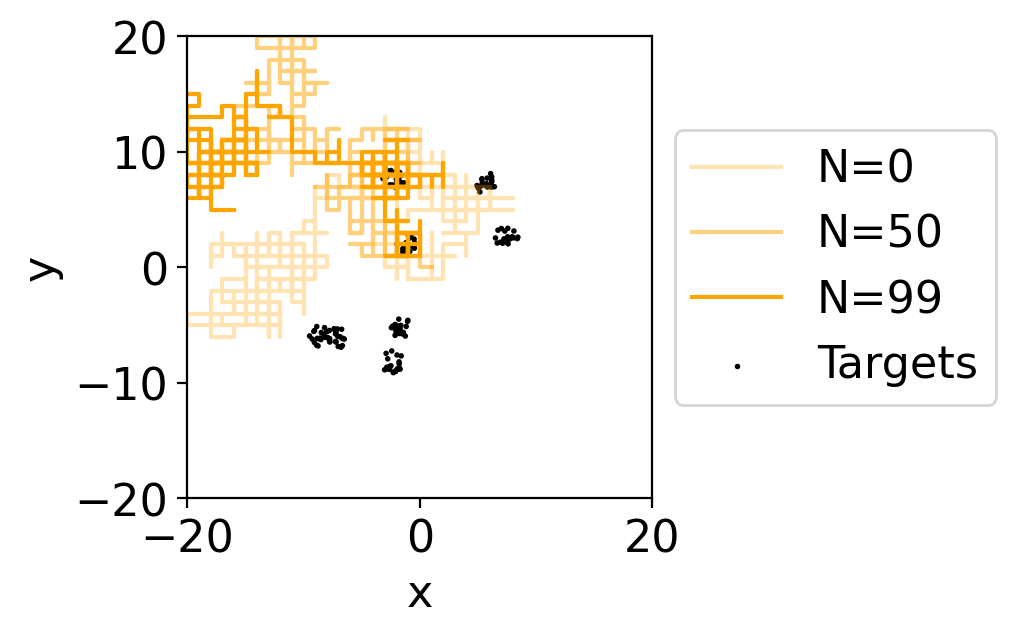

In [32]:
plot_boundary = (20, 20)

# -
num_experiment = 0
ax = None
ax = plot_position2d(
    select_exp(rl_exp, num_experiment),
    boundary=plot_boundary,
    label=f"N={num_experiment}",
    color="orange",
    alpha=0.3,
    ax=ax,
)
num_experiment = 50
ax = plot_position2d(
    select_exp(rl_exp, num_experiment),
    boundary=plot_boundary,
    label=f"N={num_experiment}",
    color="orange",
    alpha=0.5,
    ax=ax,
)
num_experiment = 99
ax = plot_position2d(
    select_exp(rl_exp, num_experiment),
    boundary=plot_boundary,
    label=f"N={num_experiment}",
    color="orange",
    alpha=1,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Notice how much more structured the search becomes areound the patches with more practice. Not great, but getting there.

**Reward value, in time**

Now let's look at the value ($Q$-value in this case) of the optimal value (i.e., $max(Q(a))$) across time for each of these three stages of learning.

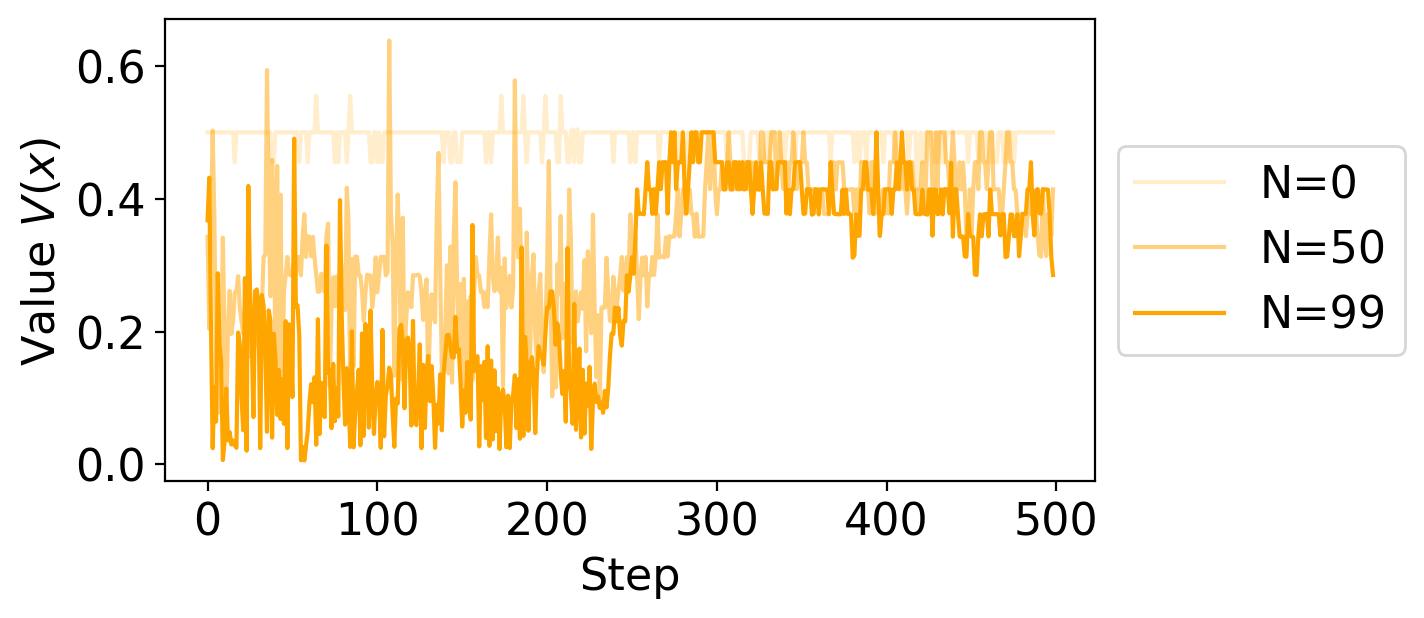

In [33]:
fig = plt.figure(figsize=(6, 3))
plt.plot(rl_exp[0]["agent_reward_value"], label="N=0", color="orange", alpha=0.2)
plt.plot(rl_exp[50]["agent_reward_value"], label="N=50", color="orange", alpha=0.5)
plt.plot(rl_exp[99]["agent_reward_value"], label="N=99", color="orange", alpha=1)
plt.ylabel("Value $V(x)$")
plt.xlabel("Step")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

---
### Question 3.1

What do you see in this behavior of the RL agent over time?

__Answer:__

The **agent improves by learning** to exploit high-reward actions while minimizing random exploration over time. I think this progression reflects how reinforcement learning enables the agent to optimize behavior through trial and error.

**Looking across simulations**

Now let's plot our metrics and see how the two agents did.

**Death**

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

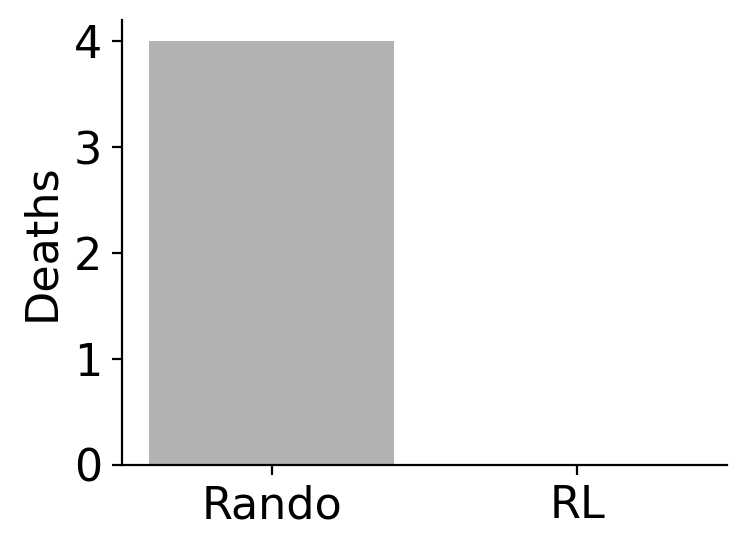

In [34]:
# Results
results = [rand_exp, rl_exp]
names = ["Rando", "RL"]
colors = ["grey", "orange"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

**Total reward**

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

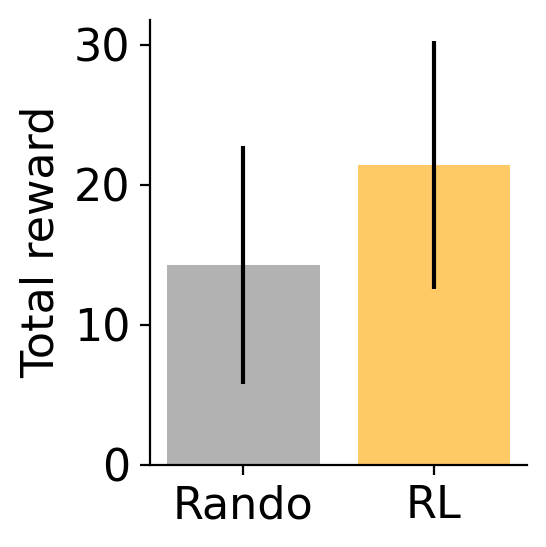

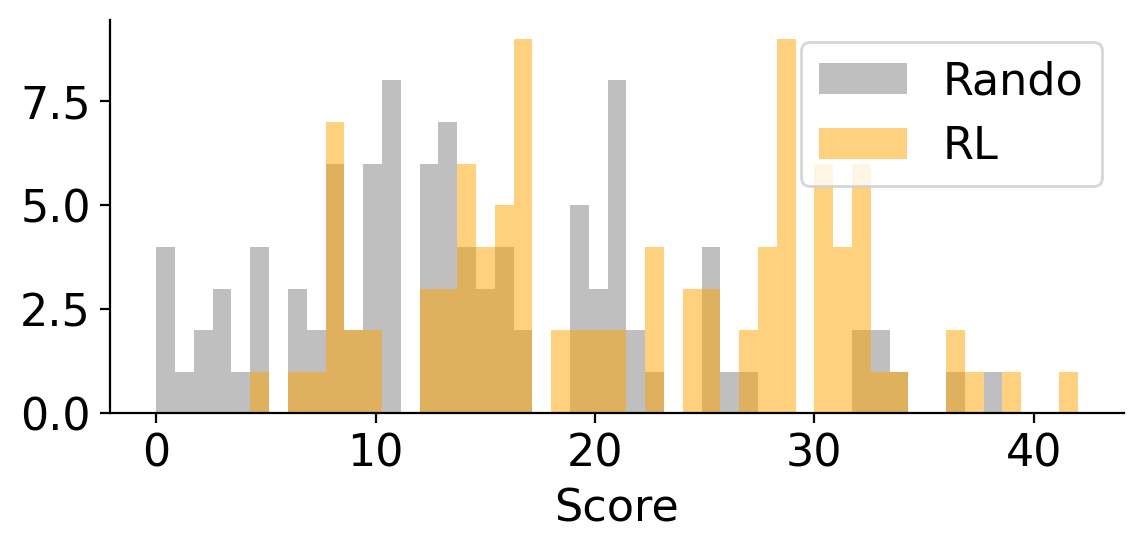

In [35]:
# Results
results = [rand_exp, rl_exp]
names = ["Rando", "RL"]
colors = ["grey", "orange"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(6, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

---
### Question 3.2

How does the performance of the RL agent compare, across all performance metrics, to the random agent? Is this a fair comparison? Why or why not?

__Answer:__

The **RL agent outperforms the random agent in all metrics**. It **collects more rewards** by learning and optimizing its actions and experiences **fewer** (essentially no) **deaths** by avoiding inefficient moves. However, this comparison is not entirely fair because the RL agent uses reinforcement learning to adapt and improve, while the random agent lacks any learning capability.


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*